In [1]:
import pandas as pd
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from tqdm.notebook import tqdm
import timm
from sklearn.model_selection import train_test_split

import  metrics
import train_utils
import importlib
importlib.reload(metrics)
importlib.reload(train_utils)

<module 'train_utils' from '/home/david/Repos/FMI/Google-Landmark-Recognition-2021/train_utils.py'>

In [2]:
bg_landmarks_ids = pd.read_csv("bg_landmarks.csv", sep='\t')
print(f"BG has {len(bg_landmarks_ids)} landmarks")

BG has 658 landmarks


In [90]:
BASE_PATH = "/home/david/Downloads/landmark-recognition-2021"

train_df = pd.read_csv(BASE_PATH + "/train.csv")

In [4]:
device = train_utils.get_device()

12.1
cuda available: True
device: cuda


In [5]:
bg_train_df = train_df[train_df['landmark_id'].isin(bg_landmarks_ids['landmark_id'])]
bg_train_df

,id,landmark_id
3959,4db638f8d0dc1ce2,481
3960,4e454120ba3bfb36,481
3961,69ba8a4a5ecc9c61,481
3962,81dc5e647b5e9c8b,481
3963,a893e44faf1e9640,481
...,...,...
1580097,c58c445a89cc7ca9,203034
1580098,c9d6a8aa86d1fce5,203034
1580099,cc4cfcfce95fc633,203034
1580100,e48bf94f91142d96,203034


In [6]:
unique_classes = bg_train_df['landmark_id'].unique()
print(f"Unique classes: {len(unique_classes)}")

Unique classes: 339


In [7]:
# The cross entropy loss requires the index of the class instead of the label (for example [0-len(unique_classes)-1]
label_to_index = {label: idx for idx, label in enumerate(unique_classes)}

bg_train_with_index = pd.DataFrame(bg_train_df)
# Apply the mapping to the DataFrame
bg_train_with_index['label_index'] = bg_train_with_index['landmark_id'].map(label_to_index)
bg_train_df = bg_train_with_index
bg_train_df

,id,landmark_id,label_index
3959,4db638f8d0dc1ce2,481,0
3960,4e454120ba3bfb36,481,0
3961,69ba8a4a5ecc9c61,481,0
3962,81dc5e647b5e9c8b,481,0
3963,a893e44faf1e9640,481,0
...,...,...,...
1580097,c58c445a89cc7ca9,203034,338
1580098,c9d6a8aa86d1fce5,203034,338
1580099,cc4cfcfce95fc633,203034,338
1580100,e48bf94f91142d96,203034,338


In [8]:
index_to_label = {v: k for k, v in label_to_index.items()}

In [9]:
train_df, val_df = train_test_split(bg_train_df, test_size=0.1, random_state=42)
print(f"len(train_df)={len(train_df)}, len(val_df)={len(val_df)}")

len(train_df)=8476, len(val_df)=942


In [10]:
unique_classes_train = train_df['label_index'].unique()
unique_classes_val = val_df['label_index'].unique()
print(f"Unique classes train: {len(unique_classes_train)}  Unique classes val: {len(unique_classes_val)}")

Unique classes train: 338  Unique classes val: 244


In [11]:
transform_to_416 = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor()
])

In [12]:
train_dataloader, val_dataloader = train_utils.get_dataloaders(train_df,val_df, BASE_PATH, transform_to_416, batch_size=4)

In [11]:
class PretrainedClassifier(nn.Module):
    def __init__(self, pretrained_model, out_size, num_classes=53):
        super(PretrainedClassifier, self).__init__()
        self.base_model = timm.create_model(pretrained_model, pretrained=True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        
        # # Freeze the base model if specified
        # for param in self.base_model.parameters():
        #     param.requires_grad = False

        #making a classfier
        self.classifier = nn.Linear(out_size, num_classes)

    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output
    

In [37]:
    
efficient_net = PretrainedClassifier(num_classes=len(unique_classes), pretrained_model='efficientnet_b5.sw_in12k', out_size=2048)

In [38]:
summary(efficient_net.to(device), (3, 416, 416))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 2048]                --
├─EfficientNet: 1                                  []                        --
|    └─Conv2d: 2-1                                 [-1, 48, 208, 208]        1,296
├─Sequential: 1                                    []                        --
|    └─Conv2d: 2-2                                 [-1, 48, 208, 208]        (recursive)
├─EfficientNet: 1                                  []                        --
|    └─BatchNormAct2d: 2-3                         [-1, 48, 208, 208]        --
├─Sequential: 1                                    []                        --
|    └─BatchNormAct2d: 2-4                         [-1, 48, 208, 208]        (recursive)
├─EfficientNet: 1                                  []                        --
|    |    └─Identity: 3-1                          [-1, 48, 208, 208]        --
├─Sequential: 

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 2048]                --
├─EfficientNet: 1                                  []                        --
|    └─Conv2d: 2-1                                 [-1, 48, 208, 208]        1,296
├─Sequential: 1                                    []                        --
|    └─Conv2d: 2-2                                 [-1, 48, 208, 208]        (recursive)
├─EfficientNet: 1                                  []                        --
|    └─BatchNormAct2d: 2-3                         [-1, 48, 208, 208]        --
├─Sequential: 1                                    []                        --
|    └─BatchNormAct2d: 2-4                         [-1, 48, 208, 208]        (recursive)
├─EfficientNet: 1                                  []                        --
|    |    └─Identity: 3-1                          [-1, 48, 208, 208]        --
├─Sequential: 

In [12]:
criterion = nn.CrossEntropyLoss()

In [40]:
optimizer = optim.Adam(efficient_net.parameters(), lr=0.001)

In [22]:
results = train_utils.train(efficient_net, train_dataloader, val_dataloader, optimizer, criterion, epochs=10,
                            train_class_labels=unique_classes_train, checkpoint_path='models/efficientnet_b5.sw_in12k', device=device)

Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

KeyboardInterrupt: 

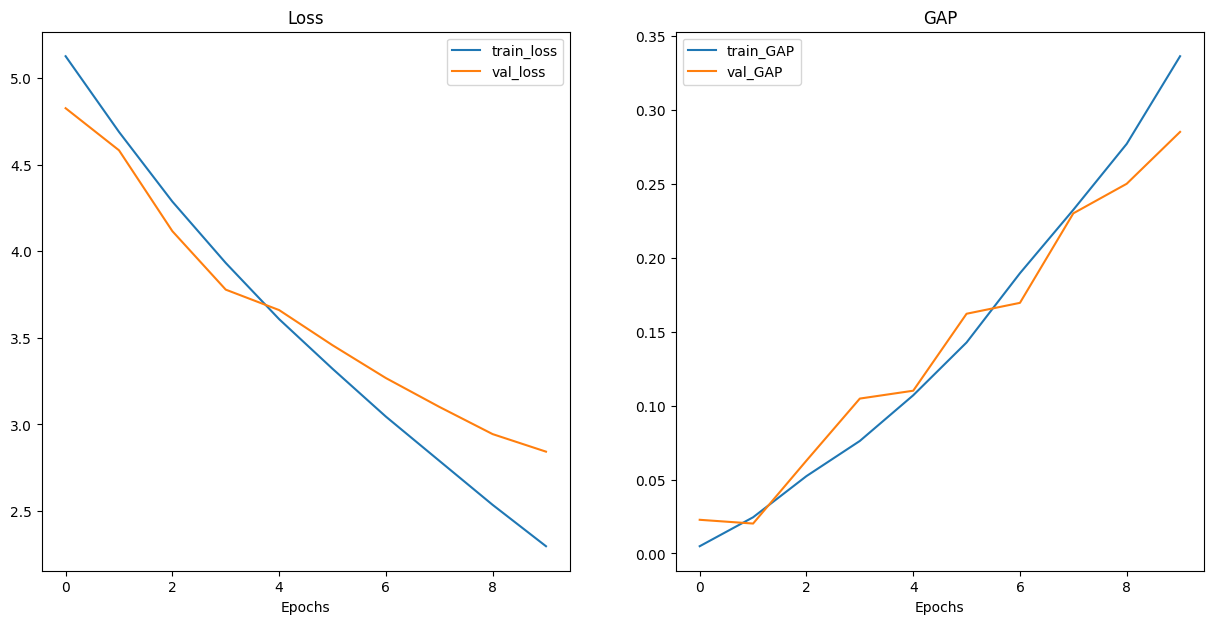

In [18]:
train_utils.plot_loss_curves(results)

In [41]:
results_50 = train_utils.train(efficient_net, train_dataloader, val_dataloader, optimizer, criterion, epochs=70,
                            train_class_labels=unique_classes_train, checkpoint_path='models/efficientnet_b5.sw_in12k_50', device=device)

Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1832 | train_GAP: 0.0038 | val_loss: 5.2265 | val_GAP: 0.0061 
Checkpoint saved at epoch 1 with validation GAP 0.006129425424011949


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 4.7493 | train_GAP: 0.0213 | val_loss: 5.0277 | val_GAP: 0.0189 
Checkpoint saved at epoch 2 with validation GAP 0.018900536547250595


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 4.3699 | train_GAP: 0.0422 | val_loss: 4.1723 | val_GAP: 0.0558 
Checkpoint saved at epoch 3 with validation GAP 0.05582737322312255


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 3.9977 | train_GAP: 0.0702 | val_loss: 3.9471 | val_GAP: 0.0954 
Checkpoint saved at epoch 4 with validation GAP 0.09536103857874438


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 3.6717 | train_GAP: 0.1037 | val_loss: 3.5993 | val_GAP: 0.1306 
Checkpoint saved at epoch 5 with validation GAP 0.13063759248010498


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 3.3607 | train_GAP: 0.1449 | val_loss: 3.4649 | val_GAP: 0.1603 
Checkpoint saved at epoch 6 with validation GAP 0.16030657728466963


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 3.0870 | train_GAP: 0.1831 | val_loss: 3.1834 | val_GAP: 0.2013 
Checkpoint saved at epoch 7 with validation GAP 0.20133580941148155


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 2.8293 | train_GAP: 0.2186 | val_loss: 2.9816 | val_GAP: 0.2437 
Checkpoint saved at epoch 8 with validation GAP 0.24374651596661703


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 2.5802 | train_GAP: 0.2676 | val_loss: 2.9089 | val_GAP: 0.2643 
Checkpoint saved at epoch 9 with validation GAP 0.2642625439353942


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 2.3334 | train_GAP: 0.3238 | val_loss: 2.7519 | val_GAP: 0.2941 
Checkpoint saved at epoch 10 with validation GAP 0.29412803899085876


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 2.0982 | train_GAP: 0.3787 | val_loss: 2.7041 | val_GAP: 0.3000 
Checkpoint saved at epoch 11 with validation GAP 0.3000151448866569


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 1.9201 | train_GAP: 0.4253 | val_loss: 2.6958 | val_GAP: 0.3343 
Checkpoint saved at epoch 12 with validation GAP 0.3342784843624193


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 1.7166 | train_GAP: 0.4787 | val_loss: 2.5096 | val_GAP: 0.3756 
Checkpoint saved at epoch 13 with validation GAP 0.37561934283701404


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 1.5295 | train_GAP: 0.5223 | val_loss: 2.5274 | val_GAP: 0.3878 
Checkpoint saved at epoch 14 with validation GAP 0.38779316963605


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 1.3721 | train_GAP: 0.5670 | val_loss: 2.5284 | val_GAP: 0.3948 
Checkpoint saved at epoch 15 with validation GAP 0.3948334478555648


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 1.1938 | train_GAP: 0.6133 | val_loss: 2.5228 | val_GAP: 0.3938 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 1.0670 | train_GAP: 0.6576 | val_loss: 2.5733 | val_GAP: 0.4128 
Checkpoint saved at epoch 17 with validation GAP 0.4128245628349317


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.9390 | train_GAP: 0.6946 | val_loss: 2.6219 | val_GAP: 0.4091 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.7980 | train_GAP: 0.7374 | val_loss: 2.7771 | val_GAP: 0.4030 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.6891 | train_GAP: 0.7720 | val_loss: 2.7648 | val_GAP: 0.4299 
Checkpoint saved at epoch 20 with validation GAP 0.4299314199544657


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 21 | train_loss: 0.5988 | train_GAP: 0.7966 | val_loss: 2.6984 | val_GAP: 0.4194 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 22 | train_loss: 0.5515 | train_GAP: 0.8155 | val_loss: 2.7129 | val_GAP: 0.4346 
Checkpoint saved at epoch 22 with validation GAP 0.4346008666185787


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 23 | train_loss: 0.4663 | train_GAP: 0.8467 | val_loss: 2.8220 | val_GAP: 0.4157 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 24 | train_loss: 0.4106 | train_GAP: 0.8602 | val_loss: 2.8696 | val_GAP: 0.4366 
Checkpoint saved at epoch 24 with validation GAP 0.43662362737546545


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 25 | train_loss: 0.3874 | train_GAP: 0.8720 | val_loss: 3.0934 | val_GAP: 0.3746 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 26 | train_loss: 0.3307 | train_GAP: 0.8923 | val_loss: 3.0062 | val_GAP: 0.4313 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 27 | train_loss: 0.3083 | train_GAP: 0.8988 | val_loss: 2.9475 | val_GAP: 0.4115 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 28 | train_loss: 0.2969 | train_GAP: 0.9007 | val_loss: 2.9267 | val_GAP: 0.4381 
Checkpoint saved at epoch 28 with validation GAP 0.4381073065220297


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 29 | train_loss: 0.2533 | train_GAP: 0.9165 | val_loss: 3.1146 | val_GAP: 0.4158 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 30 | train_loss: 0.2237 | train_GAP: 0.9273 | val_loss: 3.3238 | val_GAP: 0.4004 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 31 | train_loss: 0.2380 | train_GAP: 0.9221 | val_loss: 3.0245 | val_GAP: 0.4282 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 32 | train_loss: 0.1931 | train_GAP: 0.9392 | val_loss: 3.1289 | val_GAP: 0.4340 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 33 | train_loss: 0.2099 | train_GAP: 0.9300 | val_loss: 3.1858 | val_GAP: 0.4214 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 34 | train_loss: 0.1665 | train_GAP: 0.9478 | val_loss: 3.2416 | val_GAP: 0.4272 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 35 | train_loss: 0.1703 | train_GAP: 0.9446 | val_loss: 3.1916 | val_GAP: 0.4269 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 36 | train_loss: 0.1660 | train_GAP: 0.9462 | val_loss: 3.1749 | val_GAP: 0.4404 
Checkpoint saved at epoch 36 with validation GAP 0.44041837015765506


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 37 | train_loss: 0.1502 | train_GAP: 0.9485 | val_loss: 3.3766 | val_GAP: 0.3884 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 38 | train_loss: 0.1472 | train_GAP: 0.9528 | val_loss: 3.1488 | val_GAP: 0.4568 
Checkpoint saved at epoch 38 with validation GAP 0.45679541851876115


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 39 | train_loss: 0.1377 | train_GAP: 0.9564 | val_loss: 3.4597 | val_GAP: 0.4094 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 40 | train_loss: 0.1425 | train_GAP: 0.9552 | val_loss: 3.2473 | val_GAP: 0.4450 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 41 | train_loss: 0.1365 | train_GAP: 0.9572 | val_loss: 3.2298 | val_GAP: 0.4408 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 42 | train_loss: 0.1250 | train_GAP: 0.9598 | val_loss: 3.4510 | val_GAP: 0.4099 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 43 | train_loss: 0.1071 | train_GAP: 0.9651 | val_loss: 3.4758 | val_GAP: 0.4020 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 44 | train_loss: 0.1127 | train_GAP: 0.9631 | val_loss: 3.3933 | val_GAP: 0.4142 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 45 | train_loss: 0.1085 | train_GAP: 0.9653 | val_loss: 3.4164 | val_GAP: 0.4090 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 46 | train_loss: 0.1090 | train_GAP: 0.9657 | val_loss: 3.4962 | val_GAP: 0.4022 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 47 | train_loss: 0.1003 | train_GAP: 0.9679 | val_loss: 3.5123 | val_GAP: 0.4005 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 48 | train_loss: 0.0952 | train_GAP: 0.9695 | val_loss: 3.3182 | val_GAP: 0.4471 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 49 | train_loss: 0.1073 | train_GAP: 0.9646 | val_loss: 3.4928 | val_GAP: 0.4252 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 50 | train_loss: 0.0886 | train_GAP: 0.9712 | val_loss: 3.5148 | val_GAP: 0.4137 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 51 | train_loss: 0.0915 | train_GAP: 0.9716 | val_loss: 3.6414 | val_GAP: 0.4137 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 52 | train_loss: 0.0882 | train_GAP: 0.9725 | val_loss: 3.5551 | val_GAP: 0.4114 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 53 | train_loss: 0.0906 | train_GAP: 0.9699 | val_loss: 3.5020 | val_GAP: 0.4388 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 54 | train_loss: 0.0742 | train_GAP: 0.9785 | val_loss: 3.8105 | val_GAP: 0.4049 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 55 | train_loss: 0.0900 | train_GAP: 0.9715 | val_loss: 3.6316 | val_GAP: 0.4076 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 56 | train_loss: 0.0752 | train_GAP: 0.9771 | val_loss: 3.4805 | val_GAP: 0.4527 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 57 | train_loss: 0.0753 | train_GAP: 0.9775 | val_loss: 3.6610 | val_GAP: 0.4405 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 58 | train_loss: 0.0824 | train_GAP: 0.9747 | val_loss: 3.4325 | val_GAP: 0.4502 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 59 | train_loss: 0.0603 | train_GAP: 0.9820 | val_loss: 3.5218 | val_GAP: 0.4593 
Checkpoint saved at epoch 59 with validation GAP 0.45930099570921973


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 60 | train_loss: 0.0833 | train_GAP: 0.9719 | val_loss: 3.4633 | val_GAP: 0.4487 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 61 | train_loss: 0.0710 | train_GAP: 0.9774 | val_loss: 3.7874 | val_GAP: 0.3877 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 62 | train_loss: 0.0737 | train_GAP: 0.9783 | val_loss: 3.4861 | val_GAP: 0.4558 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 63 | train_loss: 0.0647 | train_GAP: 0.9781 | val_loss: 3.6786 | val_GAP: 0.4537 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 64 | train_loss: 0.0704 | train_GAP: 0.9775 | val_loss: 3.5461 | val_GAP: 0.4475 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 65 | train_loss: 0.0602 | train_GAP: 0.9818 | val_loss: 3.6003 | val_GAP: 0.4254 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 66 | train_loss: 0.0543 | train_GAP: 0.9831 | val_loss: 3.5610 | val_GAP: 0.4391 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 67 | train_loss: 0.0679 | train_GAP: 0.9768 | val_loss: 3.6193 | val_GAP: 0.4339 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 68 | train_loss: 0.0539 | train_GAP: 0.9833 | val_loss: 3.7288 | val_GAP: 0.4535 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 69 | train_loss: 0.0672 | train_GAP: 0.9793 | val_loss: 3.5885 | val_GAP: 0.4506 


Training loop:   0%|          | 0/2119 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/236 [00:00<?, ?it/s]

Epoch: 70 | train_loss: 0.0577 | train_GAP: 0.9821 | val_loss: 3.6167 | val_GAP: 0.4454 


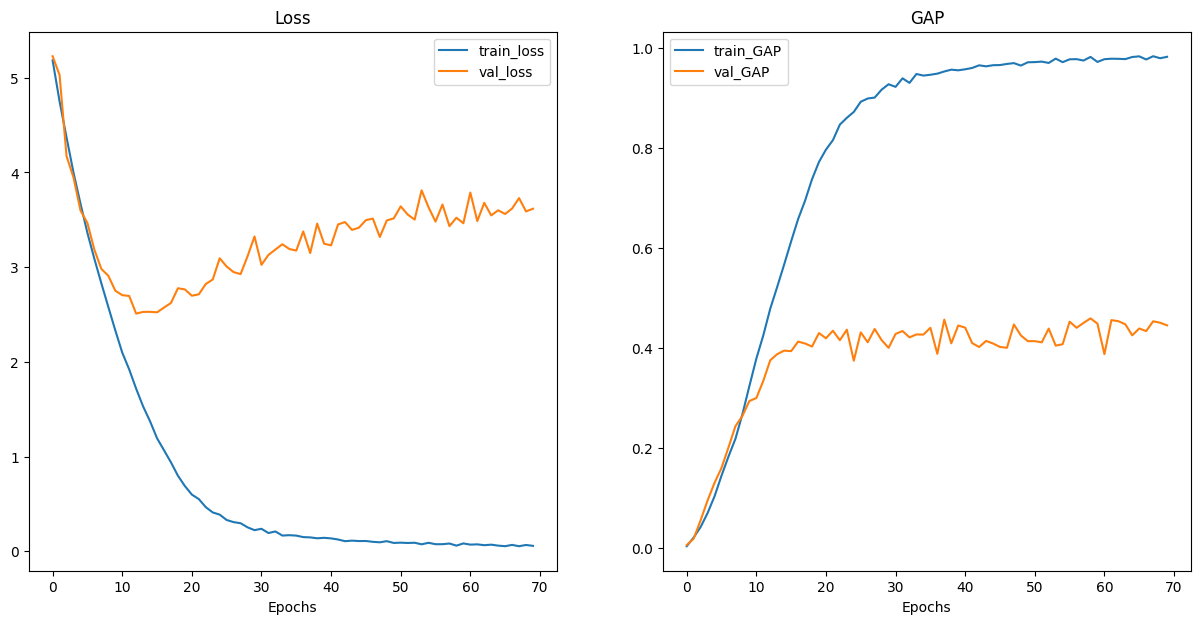

In [43]:
train_utils.plot_loss_curves(results_50)

In [36]:
# Different efficient net versions

efficientnet_b1 = PretrainedClassifier(num_classes=len(unique_classes), pretrained_model='efficientnet_b3', out_size=1536)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/efficientnet_b3.ra2_in1k)
INFO:timm.models._hub:[timm/efficientnet_b3.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


In [37]:
optimizer_b1 = optim.Adam(efficientnet_b1.parameters(), lr=0.001)

In [29]:
summary(efficientnet_b1.to(device), (3, 300, 300))

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1536]                --
├─EfficientNet: 1                                  []                        --
|    └─Conv2d: 2-1                                 [-1, 40, 150, 150]        1,080
├─Sequential: 1                                    []                        --
|    └─Conv2d: 2-2                                 [-1, 40, 150, 150]        (recursive)
├─EfficientNet: 1                                  []                        --
|    └─BatchNormAct2d: 2-3                         [-1, 40, 150, 150]        --
├─Sequential: 1                                    []                        --
|    └─BatchNormAct2d: 2-4                         [-1, 40, 150, 150]        (recursive)
├─EfficientNet: 1                                  []                        --
|    |    └─Identity: 3-1                          [-1, 40, 150, 150]        --
├─Sequential: 

Layer (type:depth-idx)                             Output Shape              Param #
├─Sequential: 1-1                                  [-1, 1536]                --
├─EfficientNet: 1                                  []                        --
|    └─Conv2d: 2-1                                 [-1, 40, 150, 150]        1,080
├─Sequential: 1                                    []                        --
|    └─Conv2d: 2-2                                 [-1, 40, 150, 150]        (recursive)
├─EfficientNet: 1                                  []                        --
|    └─BatchNormAct2d: 2-3                         [-1, 40, 150, 150]        --
├─Sequential: 1                                    []                        --
|    └─BatchNormAct2d: 2-4                         [-1, 40, 150, 150]        (recursive)
├─EfficientNet: 1                                  []                        --
|    |    └─Identity: 3-1                          [-1, 40, 150, 150]        --
├─Sequential: 

In [16]:
transform_to_192 = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

In [33]:
train_dataloader_b1, val_dataloader_b1 = train_utils.get_dataloaders(train_df,val_df, BASE_PATH, transform_to_192, batch_size=16)


In [20]:
results_b1 = train_utils.train(efficientnet_b1, train_dataloader_b1, val_dataloader_b1, optimizer_b1, criterion, epochs=20,
                            train_class_labels=unique_classes_train, checkpoint_path='models/bg_efficientnet_b1', device=device)

Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5146 | train_GAP: 0.4560 | val_loss: 1.3337 | val_GAP: 0.6604 
Checkpoint saved at epoch 1 with validation GAP 0.6603928456110881


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.6556 | train_GAP: 0.8234 | val_loss: 0.9109 | val_GAP: 0.7734 
Checkpoint saved at epoch 2 with validation GAP 0.7734172811429072


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.2110 | train_GAP: 0.9402 | val_loss: 0.7888 | val_GAP: 0.8065 
Checkpoint saved at epoch 3 with validation GAP 0.8065322182844074


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.1332 | train_GAP: 0.9629 | val_loss: 0.8270 | val_GAP: 0.7903 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1293 | train_GAP: 0.9627 | val_loss: 0.9102 | val_GAP: 0.7811 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.1663 | train_GAP: 0.9500 | val_loss: 0.9901 | val_GAP: 0.7563 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.1659 | train_GAP: 0.9511 | val_loss: 1.1492 | val_GAP: 0.7223 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.1377 | train_GAP: 0.9569 | val_loss: 0.9008 | val_GAP: 0.7799 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.0758 | train_GAP: 0.9783 | val_loss: 0.8710 | val_GAP: 0.8017 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.0626 | train_GAP: 0.9834 | val_loss: 0.9862 | val_GAP: 0.7807 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.0901 | train_GAP: 0.9750 | val_loss: 1.0498 | val_GAP: 0.7837 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.1028 | train_GAP: 0.9686 | val_loss: 0.9700 | val_GAP: 0.7926 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.1085 | train_GAP: 0.9657 | val_loss: 0.9977 | val_GAP: 0.7755 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.0919 | train_GAP: 0.9741 | val_loss: 0.9764 | val_GAP: 0.7853 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.0708 | train_GAP: 0.9782 | val_loss: 0.9723 | val_GAP: 0.7814 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.0751 | train_GAP: 0.9789 | val_loss: 0.9091 | val_GAP: 0.7976 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.0682 | train_GAP: 0.9799 | val_loss: 0.9412 | val_GAP: 0.7971 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.0598 | train_GAP: 0.9828 | val_loss: 0.8706 | val_GAP: 0.8057 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.0541 | train_GAP: 0.9846 | val_loss: 0.8932 | val_GAP: 0.8111 
Checkpoint saved at epoch 19 with validation GAP 0.8111425923550928


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.0676 | train_GAP: 0.9805 | val_loss: 1.0018 | val_GAP: 0.7790 


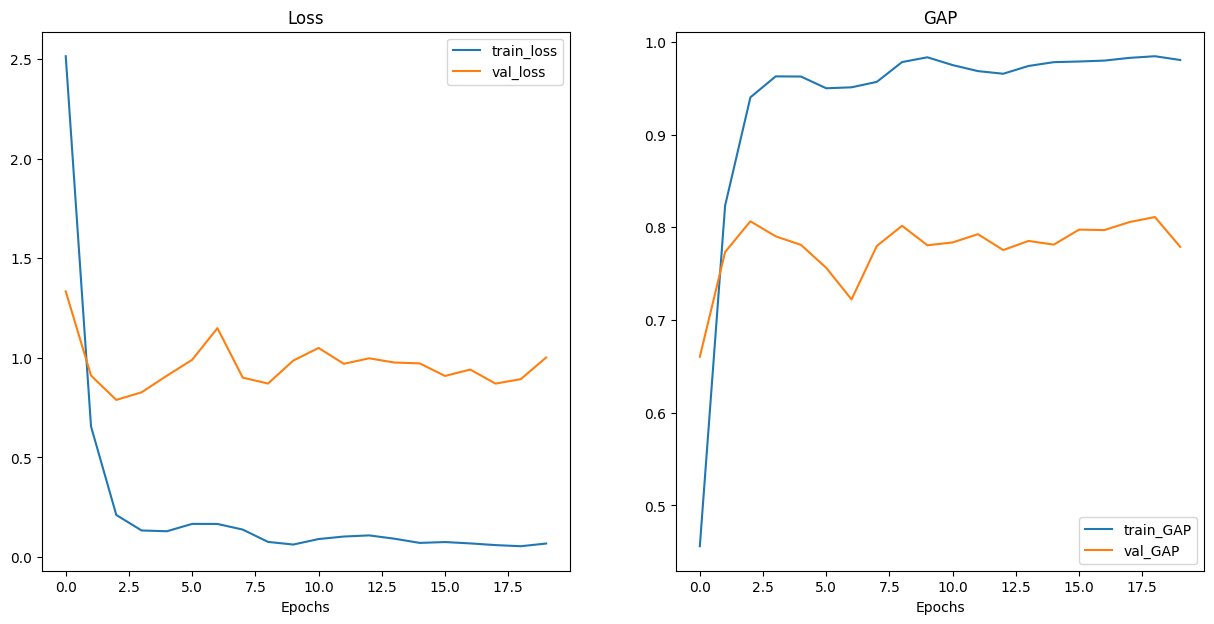

In [21]:
#Plot for b1 model 192x192
train_utils.plot_loss_curves(results_b1)

In [30]:
results_b1 = train_utils.train(efficientnet_b1, train_dataloader_b1, val_dataloader_b1, optimizer_b1, criterion, epochs=20,
                            train_class_labels=unique_classes_train, checkpoint_path='models/bg_efficientnet_b2', device=device)

Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7118 | train_GAP: 0.3976 | val_loss: 1.5839 | val_GAP: 0.5985 
Checkpoint saved at epoch 1 with validation GAP 0.5985369854832622


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.8305 | train_GAP: 0.7669 | val_loss: 1.0927 | val_GAP: 0.6991 
Checkpoint saved at epoch 2 with validation GAP 0.6990537958626211


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3526 | train_GAP: 0.8900 | val_loss: 0.9430 | val_GAP: 0.7543 
Checkpoint saved at epoch 3 with validation GAP 0.7543190037067902


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.2196 | train_GAP: 0.9354 | val_loss: 0.8928 | val_GAP: 0.7771 
Checkpoint saved at epoch 4 with validation GAP 0.7771223256597249


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1789 | train_GAP: 0.9448 | val_loss: 1.0401 | val_GAP: 0.7356 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.1716 | train_GAP: 0.9471 | val_loss: 0.8970 | val_GAP: 0.7829 
Checkpoint saved at epoch 6 with validation GAP 0.7828832440152252


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.1218 | train_GAP: 0.9641 | val_loss: 0.9771 | val_GAP: 0.7586 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.1897 | train_GAP: 0.9402 | val_loss: 1.1276 | val_GAP: 0.7177 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.1637 | train_GAP: 0.9512 | val_loss: 0.9433 | val_GAP: 0.7643 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.0806 | train_GAP: 0.9764 | val_loss: 0.8614 | val_GAP: 0.7957 
Checkpoint saved at epoch 10 with validation GAP 0.7957101247242893


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.0750 | train_GAP: 0.9763 | val_loss: 0.9209 | val_GAP: 0.7880 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.1099 | train_GAP: 0.9675 | val_loss: 1.0592 | val_GAP: 0.7582 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.1373 | train_GAP: 0.9583 | val_loss: 1.0735 | val_GAP: 0.7454 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.1154 | train_GAP: 0.9642 | val_loss: 1.1541 | val_GAP: 0.7525 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.0836 | train_GAP: 0.9739 | val_loss: 0.9621 | val_GAP: 0.8002 
Checkpoint saved at epoch 15 with validation GAP 0.8001632329444511


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.0851 | train_GAP: 0.9730 | val_loss: 1.1152 | val_GAP: 0.7435 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.0859 | train_GAP: 0.9738 | val_loss: 0.9489 | val_GAP: 0.8031 
Checkpoint saved at epoch 17 with validation GAP 0.803131117644574


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.0547 | train_GAP: 0.9834 | val_loss: 1.0600 | val_GAP: 0.7861 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.1080 | train_GAP: 0.9695 | val_loss: 1.0359 | val_GAP: 0.7719 


Training loop:   0%|          | 0/265 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.0883 | train_GAP: 0.9739 | val_loss: 1.1167 | val_GAP: 0.7756 


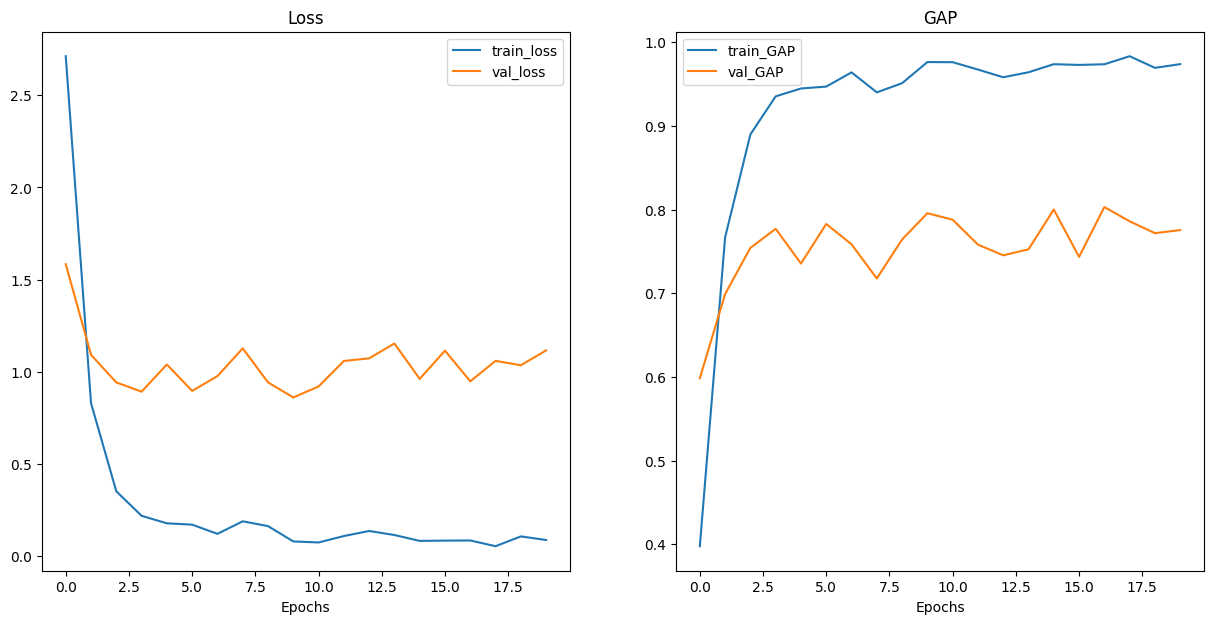

In [44]:
#Plot for b2 model 260x260
train_utils.plot_loss_curves(results_b1)

In [18]:
results_b3 = train_utils.train(efficientnet_b1, train_dataloader_b1, val_dataloader_b1, optimizer_b1, criterion, epochs=20,
                            train_class_labels=unique_classes_train, checkpoint_path='models/bg_efficientnet_b3', device=device)

Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5268 | train_GAP: 0.4301 | val_loss: 1.3092 | val_GAP: 0.6546 
Checkpoint saved at epoch 1 with validation GAP 0.6545955398955706


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 0.7379 | train_GAP: 0.7861 | val_loss: 0.8721 | val_GAP: 0.7779 
Checkpoint saved at epoch 2 with validation GAP 0.777861638584158


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 0.3469 | train_GAP: 0.8921 | val_loss: 0.7452 | val_GAP: 0.8041 
Checkpoint saved at epoch 3 with validation GAP 0.8040577387209855


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 0.2044 | train_GAP: 0.9374 | val_loss: 0.7635 | val_GAP: 0.8039 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5 | train_loss: 0.1818 | train_GAP: 0.9433 | val_loss: 0.8073 | val_GAP: 0.8103 
Checkpoint saved at epoch 5 with validation GAP 0.8103128789774717


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 6 | train_loss: 0.1906 | train_GAP: 0.9421 | val_loss: 0.8517 | val_GAP: 0.7972 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 7 | train_loss: 0.1513 | train_GAP: 0.9539 | val_loss: 0.7634 | val_GAP: 0.8114 
Checkpoint saved at epoch 7 with validation GAP 0.8113755584879941


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 8 | train_loss: 0.1307 | train_GAP: 0.9605 | val_loss: 0.6903 | val_GAP: 0.8405 
Checkpoint saved at epoch 8 with validation GAP 0.8404771351106077


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 9 | train_loss: 0.1276 | train_GAP: 0.9586 | val_loss: 0.7961 | val_GAP: 0.8129 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 10 | train_loss: 0.1011 | train_GAP: 0.9688 | val_loss: 0.8588 | val_GAP: 0.8167 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 11 | train_loss: 0.1027 | train_GAP: 0.9693 | val_loss: 0.9539 | val_GAP: 0.7710 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 12 | train_loss: 0.1178 | train_GAP: 0.9616 | val_loss: 0.6815 | val_GAP: 0.8529 
Checkpoint saved at epoch 12 with validation GAP 0.8529361576586243


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 13 | train_loss: 0.1093 | train_GAP: 0.9670 | val_loss: 0.8102 | val_GAP: 0.8217 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 14 | train_loss: 0.1009 | train_GAP: 0.9707 | val_loss: 0.7706 | val_GAP: 0.8325 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 15 | train_loss: 0.0567 | train_GAP: 0.9819 | val_loss: 0.7397 | val_GAP: 0.8523 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 16 | train_loss: 0.0857 | train_GAP: 0.9750 | val_loss: 0.9037 | val_GAP: 0.8055 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 17 | train_loss: 0.0981 | train_GAP: 0.9677 | val_loss: 0.9201 | val_GAP: 0.8147 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 18 | train_loss: 0.0609 | train_GAP: 0.9820 | val_loss: 0.7928 | val_GAP: 0.8360 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 19 | train_loss: 0.0881 | train_GAP: 0.9727 | val_loss: 1.0098 | val_GAP: 0.8119 


Training loop:   0%|          | 0/530 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 20 | train_loss: 0.0686 | train_GAP: 0.9781 | val_loss: 0.9156 | val_GAP: 0.8196 


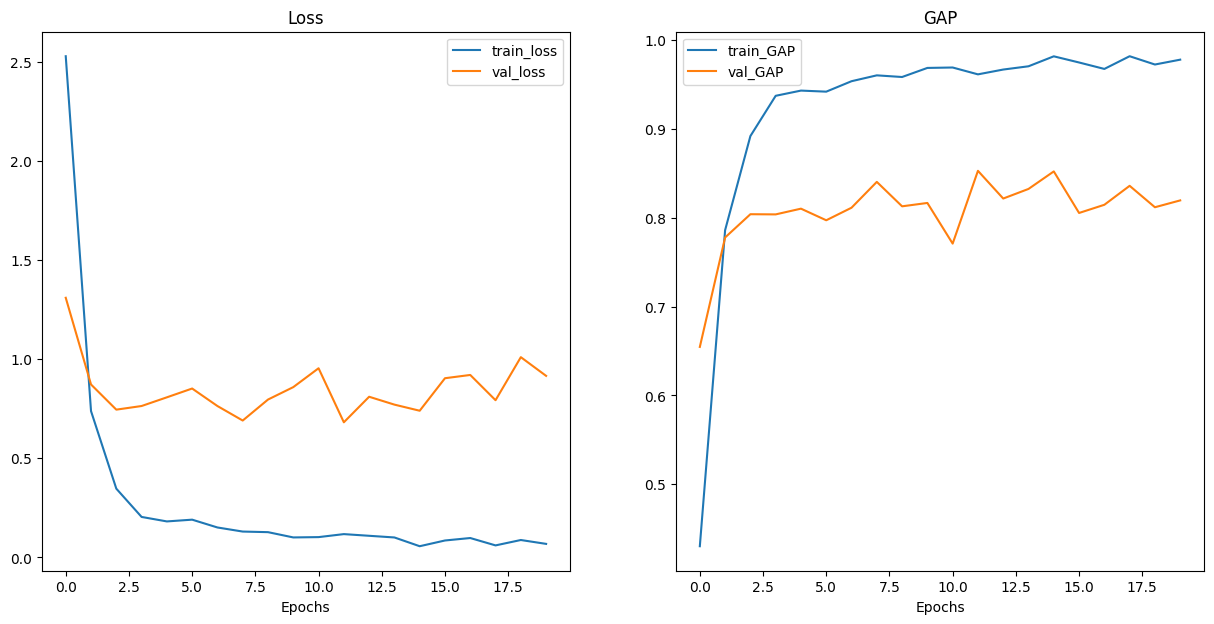

In [20]:
# Plot for b3 model 300x300
train_utils.plot_loss_curves(results_b3)

In [21]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [24]:
image_size = 300
transform_albumenation = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.ImageCompression(quality_lower=99, quality_upper=100),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        A.Resize(image_size, image_size),
        ToTensorV2(),
    ]
)



In [25]:
train_dataloader_b1, val_dataloader_b1 = train_utils.get_dataloaders(train_df,val_df, BASE_PATH, transform_albumenation, batch_size=16)

In [ ]:
results_b3_albu = train_utils.train(efficientnet_b1, train_dataloader_b1, val_dataloader_b1, optimizer_b1, criterion, epochs=20,
                            train_class_labels=unique_classes_train, checkpoint_path='models/bg_efficientnet_b3_albu', device=device)

In [38]:
import torch
def load_model(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Loaded model checkpoint: {checkpoint_path} from epoch {epoch} with validation loss: {loss:.4f}")
    dict = {'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss}
    return dict


load_model(efficientnet_b1, optimizer_b1, 'models/bg_efficientnet_b3')
gap_2, df_with_confidence = metrics.calculate_gap(efficientnet_b1, val_dataloader_b1, unique_classes_train, device)
print(f"Global Average Precision (GAP): {gap_2:.4f}")

Loaded model checkpoint: models/bg_efficientnet_b3 from epoch 11 with validation loss: 0.6815


Evaluating model:   0%|          | 0/59 [00:00<?, ?it/s]

Global Average Precision (GAP): 0.8529


In [39]:
df_with_confidence

,index,label_index,prediction,confidence
0,0,261,261,1.000000
1,679,156,156,1.000000
2,401,16,16,1.000000
3,652,255,255,1.000000
4,89,139,139,1.000000
...,...,...,...,...
937,332,247,175,0.270532
938,342,80,25,0.256573
939,785,101,98,0.215129
940,132,269,223,0.194280


In [80]:
wrong_predictions = df_with_confidence[df_with_confidence['label_index'] != df_with_confidence['prediction']]

In [81]:
wrong_predictions

,index,label_index,prediction,confidence
319,476,257,139,0.999963
401,927,337,277,0.999786
491,347,337,277,0.998673
544,415,234,309,0.997069
554,308,113,303,0.996403
...,...,...,...,...
937,332,247,175,0.270532
938,342,80,25,0.256573
939,785,101,98,0.215129
940,132,269,223,0.194280


In [83]:
# Group by 'label_index' and count occurrences
grouped_df = train_df.groupby('label_index').size().reset_index(name='images_in_train')

# Sort by count in descending order
label_index_by_count = grouped_df.sort_values(by='images_in_train', ascending=False)
label_index_by_count

,label_index,images_in_train
36,36,459
11,11,333
16,16,282
155,156,271
98,98,224
...,...,...
47,47,1
253,254,1
259,260,1
236,237,1


In [84]:
wrong_predictions = wrong_predictions.merge(label_index_by_count, on='label_index', how='left')

In [89]:
wrong_predictions

,index,label_index,prediction,confidence,images_in_train
0,476,Sofia_Central_Mineral_Baths,Central_Market_Hall_in_Sofia,0.999963,64.0
1,927,"Patriarchal_Cathedral,_Veliko_Tarnovo",Tsarevets,0.999786,48.0
2,347,"Patriarchal_Cathedral,_Veliko_Tarnovo",Tsarevets,0.998673,48.0
3,415,Razboishte_Monastery,Dryanovo_Monastery,0.997069,9.0
4,308,Popovo_ezero,Pirin_National_Park,0.996403,45.0
...,...,...,...,...,...
124,332,Shumen_Fortress,Baba_Vida_Fortress,0.270532,34.0
125,342,Asen's_Fortress,Ropotamo_(nature_reserve),0.256573,79.0
126,785,Dobrostanski_biser,Pirin,0.215129,NaN
127,132,Dzhengal,Chairski_Lakes,0.194280,8.0


In [58]:
def read_csv_to_dict(csv_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Convert the DataFrame to a dictionary
    landmark_dict = df.set_index('landmark_id')['category'].to_dict()

    return landmark_dict

csv_file_path = BASE_PATH + '/train_label_to_category.csv'  # Replace with the path to your CSV file
landmark_id_to_wikimedia = read_csv_to_dict(csv_file_path)

In [86]:
landmark_id_to_wikimedia_modified = {k: v.replace('http://commons.wikimedia.org/wiki/Category:', '') for k, v in landmark_id_to_wikimedia.items()}

wrong_predictions['label_index'] = wrong_predictions['label_index'].map(index_to_label)
wrong_predictions['prediction'] = wrong_predictions['prediction'].map(index_to_label)

# Replace values in 'label_index' and 'prediction' columns using the modified dictionary
wrong_predictions['label_index'] = wrong_predictions['label_index'].map(landmark_id_to_wikimedia_modified)
wrong_predictions['prediction'] = wrong_predictions['prediction'].map(landmark_id_to_wikimedia_modified)

wrong_predictions

,index,label_index,prediction,confidence,images_in_train
0,476,Sofia_Central_Mineral_Baths,Central_Market_Hall_in_Sofia,0.999963,64.0
1,927,"Patriarchal_Cathedral,_Veliko_Tarnovo",Tsarevets,0.999786,48.0
2,347,"Patriarchal_Cathedral,_Veliko_Tarnovo",Tsarevets,0.998673,48.0
3,415,Razboishte_Monastery,Dryanovo_Monastery,0.997069,9.0
4,308,Popovo_ezero,Pirin_National_Park,0.996403,45.0
...,...,...,...,...,...
124,332,Shumen_Fortress,Baba_Vida_Fortress,0.270532,34.0
125,342,Asen's_Fortress,Ropotamo_(nature_reserve),0.256573,79.0
126,785,Dobrostanski_biser,Pirin,0.215129,NaN
127,132,Dzhengal,Chairski_Lakes,0.194280,8.0


In [88]:
# Top 10 wrong predictions
wrong_predictions.head(10)

,index,label_index,prediction,confidence,images_in_train
0,476,Sofia_Central_Mineral_Baths,Central_Market_Hall_in_Sofia,0.999963,64.0
1,927,"Patriarchal_Cathedral,_Veliko_Tarnovo",Tsarevets,0.999786,48.0
2,347,"Patriarchal_Cathedral,_Veliko_Tarnovo",Tsarevets,0.998673,48.0
3,415,Razboishte_Monastery,Dryanovo_Monastery,0.997069,9.0
4,308,Popovo_ezero,Pirin_National_Park,0.996403,45.0
5,493,"Covered_bridge,_Lovech",Mustafa_Pasha_Bridge,0.991783,27.0
6,653,Djumaya_Mosque_(Plovdiv),%C5%9Eahabettin_%C4%B0maret_Mosque,0.984013,17.0
7,34,"Sts._Theodore_Tyron_%26_Theodore_Stratelates,_...",Boyana_Church,0.981916,2.0
8,871,Batak_History_Museum,Dryanovo_Monastery,0.980509,6.0
9,557,Dzhendema,Rila_National_Park,0.977789,59.0
